In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 4.7 MB/s 
     |████████████████████████████████| 182 kB 88.4 MB/s 
     |████████████████████████████████| 7.6 MB 77.3 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from torch import nn
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import torch
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
from torch.utils.data import Dataset, DataLoader, random_split
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from sklearn.feature_extraction.text import TfidfVectorizer
from torchtext.vocab import GloVe,vocab
from transformers import BertTokenizer, BertModel, BertConfig,BertForSequenceClassification, BertPreTrainedModel
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW,
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification,
                          GPT2PreTrainedModel,
                          GPT2Model)
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score
from typing import Optional, Tuple, Union
from transformers.modeling_outputs import SequenceClassifierOutputWithPast

In [ ]:
def convert_personality_type_to_binary(mbti_type):
    mapper = {
        'I':0,
        'E':1,
        'N':0,
        'S':1,
        'T':0,
        'F':1,
        'J':0,
        'P':1,
    }

    return [mapper[i] for i in mbti_type]

def convert_personality_type_to_int(mbti_type):
    types = [
                'INTJ', 'INTP', 'ISFJ', 'ISFP',
                'ISTJ', 'ISTP', 'ENFJ', 'ENFP',
                'ENTJ', 'ENTP','ESFJ', 'ESFP',
                'ESTJ', 'ESTP', 'INFJ', 'INFP'
            ]
    ints = [i for i in range(len(types))]
    mapper = dict(zip(types, ints))

    return mapper[mbti_type]

def convert_binary_to_personality_type(binary_mbti_type):
    mbti_arrays = [['I', 'E'], ['N', 'S'], ['T', 'F'], ['J', 'P']]
    mbti_string = ''
    for idx, mbti_type in enumerate(binary_mbti_type):
        mbti_string += mbti_arrays[idx][int(mbti_type)]
    return mbti_string

In [ ]:
class MBTIDataset(Dataset):
    def __init__(self, data_path, vectorizing_method = None, binary_outputs = False, max_seq_len=500):
        """
        Vectorizing methods:
        None - returns raw text
        basic - basic builtin pytorch vectorizer
        TfIdf - tf-idf vectorizer
        GloVe - Global Vectors pretrained embedding
        """
        self.df = pd.read_csv(data_path)
        self.vectorizing_method = vectorizing_method
        self.max_seq_len = max_seq_len
        self.split_dataframe(self.max_seq_len)

        if vectorizing_method:
            if vectorizing_method.lower == 'basic':
                self.tokenizer = get_tokenizer('basic_english')
                self.vocab = build_vocab_from_iterator(self.yield_tokens_from_dataframe(), specials=['<unk>'])
                self.vocab.set_default_index(self.vocab["<unk>"])

            if vectorizing_method.lower == 'tfidf' or vectorizing_method.lower == 'tf-idf':
                self.tokenizer = TfidfVectorizer(stop_words= 'english')
                self.vocab = self.tokenizer.fit_transform(self.df['posts']) # Sparse matrix representation - could use different field names
            if vectorizing_method.lower == 'glove':
                unk_index = 0
                self.global_vectors = GloVe(name='6B', dim=50)
                self.vocab=vocab(self.global_vectors.stoi)
                self.vocab.insert_token("<unk>",unk_index)
                self.vocab.set_default_index(unk_index)

                self.pretrained_embeddings = self.global_vectors.vectors
                self.pretrained_embeddings = torch.cat((torch.zeros(1,self.pretrained_embeddings.shape[1]),self.pretrained_embeddings))


        self.binary_outputs = binary_outputs
        if binary_outputs:
            self.df['type'] = self.df['type'].apply(convert_personality_type_to_binary)
        else:
            self.df['type'] = self.df['type'].apply(convert_personality_type_to_int)

    def yield_tokens_from_dataframe(self):
        for post in self.df['posts']:
            yield self.tokenizer(post)

    def split_dataframe(self, new_seq_len):
        new_df = pd.DataFrame(columns=self.df.columns)
        new_posts = []
        new_types = []
        for idx, row in self.df.iterrows():
            split_posts = row['posts'].split(' ')
            i = 0
            while i < len(split_posts):
                new_posts.append((' ').join(split_posts[i:i+new_seq_len]))
                new_types.append(row['type'])
                i += new_seq_len

        new_df['posts'] = new_posts
        new_df['type'] = new_types
        self.df = new_df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if idx >= len(self): raise IndexError

        if not self.vectorizing_method :
            return self.df['posts'][idx], self.df['type'][idx]  #Return raw text

        input_text = self.vocab(self.df['posts'][idx].split(' '))
        if len(input_text) < self.max_seq_len:
            input_text.extend([0] * (self.max_seq_len-len(input_text)))
        label = self.df['type'][idx]

        return input_text[0:self.max_seq_len], label

In [ ]:
class BERTClassificationCollator(object):

    def __init__(self, use_tokenizer, max_sequence_len=None):

        # Tokenizer to be used inside the class.
        self.use_tokenizer = use_tokenizer
        # Check max sequence length.
        self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len

        return

    def __call__(self, sequences):

        # Get all texts from sequences list.
        texts = [sequence[0] for sequence in sequences]
        # Get all labels from sequences list.
        labels = [sequence[1] for sequence in sequences]
        # Call tokenizer on all texts to convert into tensors of numbers with
        # appropriate padding.
        inputs = self.use_tokenizer(text=texts, return_tensors="pt", padding=True, truncation=True,  max_length=self.max_sequence_len)
        # Update the inputs with the associated encoded labels as tensor.
        inputs.update({'labels':torch.tensor(labels)})

        return inputs

In [ ]:
max_seq_len = 500
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer.padding_side = "right"
bert_classificaiton_collator = BERTClassificationCollator(use_tokenizer=tokenizer, max_sequence_len=max_seq_len)


ds = MBTIDataset('/content/drive/MyDrive/Colab Notebooks/NLP/MBTI 500.csv', vectorizing_method = None, binary_outputs=False, max_seq_len = max_seq_len)
train_set_size = int(len(ds)*0.7)
val_set_size = int(len(ds)*0.2)
test_set_size = len(ds) - train_set_size - val_set_size
train_ds, val_ds, test_ds = random_split(ds, [train_set_size, val_set_size, test_set_size])

train_dataloader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=bert_classificaiton_collator)
val_dataloader = DataLoader(val_ds, batch_size=8, shuffle=True, collate_fn=bert_classificaiton_collator)
test_dataloader = DataLoader(test_ds, batch_size=8, shuffle=True, collate_fn=bert_classificaiton_collator)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
train_features = next(iter(train_dataloader))


In [ ]:
example_text = 'I will watch Memento tonight'
bert_input = tokenizer(example_text,padding='max_length', max_length = 10)
print(bert_input)


{'input_ids': [101, 1045, 2097, 3422, 2033, 23065, 3892, 102, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 0, 0]}


In [ ]:
tokenizer.convert_ids_to_tokens(bert_input['input_ids'])

['[CLS]',
 'i',
 'will',
 'watch',
 'me',
 '##mento',
 'tonight',
 '[SEP]',
 '[PAD]',
 '[PAD]']

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 16, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 2e-5, # default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # default is 1e-8.
                  )

# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives
# us the number of batches.
epochs = 4
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

cuda


In [ ]:
for epoch in range(epochs):
    model.train()
    
    predictions_labels = []
    true_labels = []
    # Total loss for this epoch.
    total_loss = 0
    # For each batch of training data...
    i = 0
    i_to_zero_count = 0
    for batch in tqdm(train_dataloader, total=len(train_dataloader), position=0, leave=True):

        true_labels += batch['labels'].numpy().flatten().tolist()
        batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}
        model.zero_grad()
        outputs = model(**batch)
        loss, logits = outputs[:2]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        logits = logits.detach().cpu().numpy()
        predictions_labels += logits.argmax(axis=-1).flatten().tolist()
        
        if i % 500 == 0 :
            i=0
            i_to_zero_count += 1
            print(total_loss / (i_to_zero_count * 500 * 8))
                  
        i += 1

    avg_epoch_loss = total_loss / len(train_dataloader)
    print(avg_epoch_loss)
    
    predictions_labels = []
    true_labels = []
    total_loss = 0

    model.eval()

    # Evaluate data for one epoch
    for batch in tqdm(val_dataloader, total=len(val_dataloader), position=0, leave=True):

        true_labels += batch['labels'].numpy().flatten().tolist()
        batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}
        with torch.no_grad():        
            outputs = model(**batch)
            loss, logits = outputs[:2]
            logits = logits.detach().cpu().numpy()
            total_loss += loss.item()
            predict_content = logits.argmax(axis=-1).flatten().tolist()
            predictions_labels += predict_content

    avg_epoch_loss = total_loss / len(val_dataloader)
    print(avg_epoch_loss)

  0%|          | 1/10400 [00:02<7:20:21,  2.54s/it]

0.0007182881236076355


  5%|▍         | 501/10400 [02:34<50:05,  3.29it/s]

0.1163338288217783


 10%|▉         | 1001/10400 [05:05<48:12,  3.25it/s]

0.13084571957960725


 14%|█▍        | 1501/10400 [07:37<45:20,  3.27it/s]

0.13488850669935346


 19%|█▉        | 2001/10400 [10:09<42:57,  3.26it/s]

0.13457896334007383


 24%|██▍       | 2501/10400 [12:41<39:49,  3.31it/s]

0.13346233098985005


 29%|██▉       | 3001/10400 [15:13<36:24,  3.39it/s]

0.1319998051887378


 34%|███▎      | 3501/10400 [17:45<34:50,  3.30it/s]

0.13084023620432708


 38%|███▊      | 4001/10400 [20:17<32:56,  3.24it/s]

0.12962619094509217


 43%|████▎     | 4501/10400 [22:49<30:08,  3.26it/s]

0.1283763918704353


 48%|████▊     | 5001/10400 [25:22<27:13,  3.30it/s]

0.12727176983078772


 53%|█████▎    | 5501/10400 [27:54<25:28,  3.21it/s]

0.1259807410921591


 58%|█████▊    | 6001/10400 [30:26<22:39,  3.24it/s]

0.1251387038646409


 63%|██████▎   | 6501/10400 [32:59<19:48,  3.28it/s]

0.12400753309990147


 67%|██████▋   | 7001/10400 [35:31<17:20,  3.27it/s]

0.12315078287652383


 72%|███████▏  | 7501/10400 [38:02<15:02,  3.21it/s]

0.12240869485912845


 77%|███████▋  | 8001/10400 [40:34<12:28,  3.20it/s]

0.12164095497114913


 82%|████████▏ | 8501/10400 [43:06<09:38,  3.28it/s]

0.12083809254458173


 87%|████████▋ | 9001/10400 [45:38<07:07,  3.28it/s]

0.11997983929941333


 91%|█████████▏| 9501/10400 [48:09<04:39,  3.21it/s]

0.11915450153630226


 96%|█████████▌| 10001/10400 [50:41<01:58,  3.35it/s]

0.11837577664390916


100%|██████████| 10400/10400 [52:43<00:00,  3.29it/s]


0.9869768479093909


100%|██████████| 2972/2972 [07:43<00:00,  6.42it/s]


0.803843298688165


  0%|          | 1/10400 [00:00<53:50,  3.22it/s]

8.060206472873688e-05


  5%|▍         | 501/10400 [02:32<51:30,  3.20it/s]

0.046724296848289666


 10%|▉         | 1001/10400 [05:04<48:18,  3.24it/s]

0.06310515766094128


 14%|█▍        | 1501/10400 [07:36<44:55,  3.30it/s]

0.07135315550037194


 19%|█▉        | 2001/10400 [10:08<41:46,  3.35it/s]

0.0751522804139182


 24%|██▍       | 2501/10400 [12:41<39:29,  3.33it/s]

0.07765458507253789


 29%|██▉       | 3001/10400 [15:13<38:40,  3.19it/s]

0.08006347791055617


 34%|███▎      | 3501/10400 [17:45<34:41,  3.31it/s]

0.08161656265056809


 38%|███▊      | 4001/10400 [20:17<32:11,  3.31it/s]

0.08251181060546595


 43%|████▎     | 4501/10400 [22:49<29:55,  3.29it/s]

0.08319716876011808


 48%|████▊     | 5001/10400 [25:21<27:14,  3.30it/s]

0.08404441537337631


 53%|█████▎    | 5501/10400 [27:53<23:56,  3.41it/s]

0.08485459263046505


 58%|█████▊    | 6001/10400 [30:25<21:09,  3.47it/s]

0.08521331365227412


 63%|██████▎   | 6501/10400 [32:57<20:07,  3.23it/s]

0.08548547533917009


 67%|██████▋   | 7001/10400 [35:29<17:22,  3.26it/s]

0.08577418604289026


 72%|███████▏  | 7501/10400 [37:59<14:18,  3.38it/s]

0.08607887942472735


 77%|███████▋  | 8001/10400 [40:31<11:56,  3.35it/s]

0.0861836095745059


 82%|████████▏ | 8501/10400 [43:04<09:30,  3.33it/s]

0.08600530891168941


 87%|████████▋ | 9001/10400 [45:36<07:02,  3.31it/s]

0.08604446771955976


 91%|█████████▏| 9501/10400 [48:09<04:33,  3.29it/s]

0.0863692991378659


 96%|█████████▌| 10001/10400 [50:41<02:05,  3.18it/s]

0.086379210216409


100%|██████████| 10400/10400 [52:44<00:00,  3.29it/s]


0.7238874664218076


100%|██████████| 2972/2972 [07:44<00:00,  6.40it/s]


0.7509321431837122


  0%|          | 1/10400 [00:00<53:10,  3.26it/s]

7.047506421804429e-05


  5%|▍         | 501/10400 [02:32<50:27,  3.27it/s]

0.03722435484058224


 10%|▉         | 1001/10400 [05:04<47:15,  3.31it/s]

0.04976418867365767


 14%|█▍        | 1501/10400 [07:35<44:15,  3.35it/s]

0.05655162904667668


 19%|█▉        | 2001/10400 [10:07<42:17,  3.31it/s]

0.05981966820261441


 24%|██▍       | 2501/10400 [12:40<39:06,  3.37it/s]

0.06225081549895307


 29%|██▉       | 3001/10400 [15:12<37:39,  3.28it/s]

0.06368387306270389


 34%|███▎      | 3501/10400 [17:45<35:11,  3.27it/s]

0.0650516330976243


 38%|███▊      | 4001/10400 [20:18<32:14,  3.31it/s]

0.06551716782315634


 43%|████▎     | 4501/10400 [22:50<29:42,  3.31it/s]

0.06615433258788543


 48%|████▊     | 5001/10400 [25:22<27:25,  3.28it/s]

0.06727792794119292


 53%|█████▎    | 5501/10400 [27:54<24:49,  3.29it/s]

0.06766618997791375


 58%|█████▊    | 6001/10400 [30:27<22:03,  3.32it/s]

0.06838247491439464


 63%|██████▎   | 6501/10400 [32:59<19:17,  3.37it/s]

0.0690188054893224


 67%|██████▋   | 7001/10400 [35:32<17:10,  3.30it/s]

0.06921891537582268


 72%|███████▏  | 7501/10400 [38:04<14:53,  3.24it/s]

0.06958649600593708


 77%|███████▋  | 8001/10400 [40:37<12:04,  3.31it/s]

0.06974534399745821


 82%|████████▏ | 8501/10400 [43:10<09:53,  3.20it/s]

0.07000651430702096


 87%|████████▋ | 9001/10400 [45:42<07:10,  3.25it/s]

0.07017467294826393


 91%|█████████▏| 9501/10400 [48:14<04:35,  3.26it/s]

0.07029688678591628


 96%|█████████▌| 10001/10400 [50:47<01:58,  3.38it/s]

0.07030982427406568


100%|██████████| 10400/10400 [52:48<00:00,  3.28it/s]


0.5899828787512916


100%|██████████| 2972/2972 [07:43<00:00,  6.41it/s]


0.7915857926711928


  0%|          | 1/10400 [00:00<53:09,  3.26it/s]

0.00010096027702093124


  5%|▍         | 501/10400 [02:32<51:05,  3.23it/s]

0.02984612399461912


 10%|▉         | 1001/10400 [05:05<48:43,  3.21it/s]

0.03944596040446777


 14%|█▍        | 1501/10400 [07:36<44:08,  3.36it/s]

0.04473046169625013


 19%|█▉        | 2001/10400 [10:08<41:43,  3.35it/s]

0.047683773332100825


 24%|██▍       | 2501/10400 [12:40<38:21,  3.43it/s]

0.05017512020743258


 29%|██▉       | 3001/10400 [15:11<37:46,  3.26it/s]

0.05174069284594485


 34%|███▎      | 3501/10400 [17:43<34:26,  3.34it/s]

0.052819578071103025


 38%|███▊      | 4001/10400 [20:16<31:43,  3.36it/s]

0.053764511083537296


 43%|████▎     | 4501/10400 [22:48<29:53,  3.29it/s]

0.05433096533441567


 48%|████▊     | 5001/10400 [25:20<27:21,  3.29it/s]

0.05478162126810374


 53%|█████▎    | 5501/10400 [27:52<25:37,  3.19it/s]

0.055117025684400384


 58%|█████▊    | 6001/10400 [30:24<22:04,  3.32it/s]

0.05516923873955742


 63%|██████▎   | 6501/10400 [32:56<19:58,  3.25it/s]

0.05559353075386857


 67%|██████▋   | 7001/10400 [35:28<17:12,  3.29it/s]

0.055845151788617174


 72%|███████▏  | 7501/10400 [38:00<14:54,  3.24it/s]

0.05614890600605213


 77%|███████▋  | 8001/10400 [40:32<12:01,  3.32it/s]

0.056422021748713795


 82%|████████▏ | 8501/10400 [43:04<09:38,  3.28it/s]

0.056834187205767696


 87%|████████▋ | 9001/10400 [45:36<07:06,  3.28it/s]

0.05696125934613979


 91%|█████████▏| 9501/10400 [48:08<04:36,  3.26it/s]

0.056810988032232855


 96%|█████████▌| 10001/10400 [50:41<02:00,  3.30it/s]

0.0569520370899367


100%|██████████| 10400/10400 [52:42<00:00,  3.29it/s]


0.4790469944381822


100%|██████████| 2972/2972 [07:43<00:00,  6.42it/s]

0.8595472790849549


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/NLP/Bert_epoch4_16class.pt')

In [ ]:
torch.save(model, '/content/drive/MyDrive/Colab Notebooks/NLP/Bert_epoch4_16class_whole.pth')

In [ ]:
torch.save({'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': total_loss}, 
	    '/content/drive/MyDrive/Colab Notebooks/NLP/Bert_epoch2_16class.pth')


In [ ]:
predictions_labels = []
true_labels = []
total_loss = 0

model.eval()

# Evaluate data for one epoch
for batch in tqdm(test_dataloader, total=len(test_dataloader)):

    true_labels += batch['labels'].numpy().flatten().tolist()
    batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}
    with torch.no_grad():        
        outputs = model(**batch)
        loss, logits = outputs[:2]
        logits = logits.detach().cpu().numpy()
        total_loss += loss.item()
        predict_content = logits.argmax(axis=-1).flatten().tolist()
        predictions_labels += predict_content

avg_epoch_loss = total_loss / len(test_dataloader)
print(avg_epoch_loss)

100%|██████████| 1486/1486 [03:52<00:00,  6.40it/s]

0.8481612517499217


In [ ]:
print('Accuracy:', accuracy_score(true_labels, predictions_labels))
print('F1 score:', f1_score(true_labels, predictions_labels, average='weighted'))
print('Precision:', precision_score(true_labels, predictions_labels, average='weighted'))
print('Recall:', recall_score(true_labels, predictions_labels, average='weighted'))

Accuracy: 0.778329267266762
F1 score: 0.7792536111690341
Precision: 0.7829136377724017
Recall: 0.778329267266762


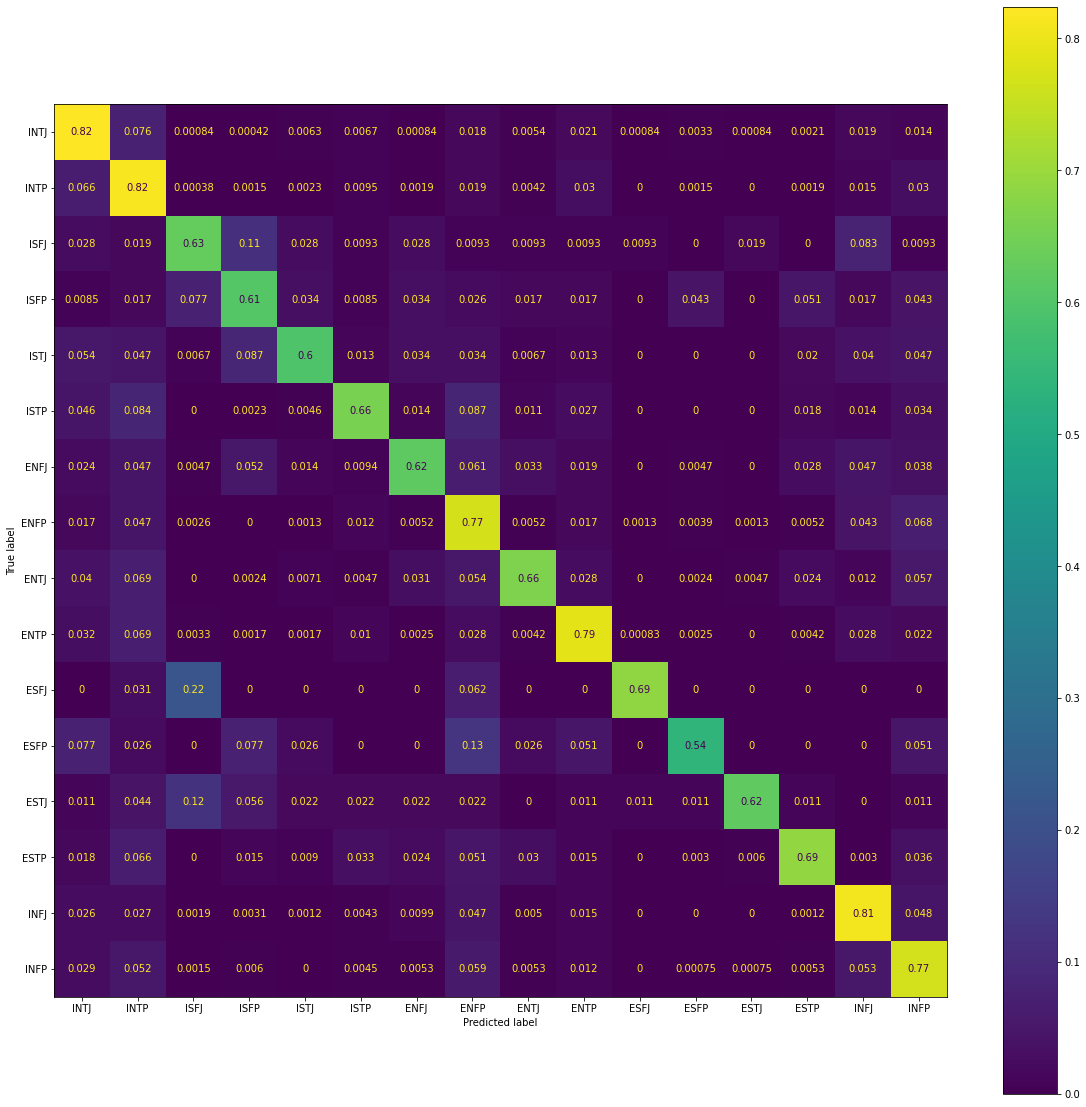

In [ ]:
mbti_types = [
                'INTJ', 'INTP', 'ISFJ', 'ISFP',
                'ISTJ', 'ISTP', 'ENFJ', 'ENFP',
                'ENTJ', 'ENTP','ESFJ', 'ESFP',
                'ESTJ', 'ESTP', 'INFJ', 'INFP'
            ]

fig, ax = plt.subplots(figsize=(20, 20))
cm = confusion_matrix(true_labels, predictions_labels, labels=[i for i in range(16)], normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mbti_types)
disp.plot(ax=ax)

Binary classficiation


In [ ]:
class BertForBinaryMBTIClassification(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.transformer = BertModel(config)
        self.EI = nn.Linear(config.hidden_size, 1, bias=False)
        self.NS = nn.Linear(config.hidden_size, 1, bias=False)
        self.TF = nn.Linear(config.hidden_size, 1, bias=False)
        self.JP = nn.Linear(config.hidden_size, 1, bias=False)

        # Model parallel
        self.model_parallel = False
        self.device_map = None

        # Initialize weights and apply final processing
        self.post_init()
        
    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        past_key_values: Optional[Tuple[Tuple[torch.Tensor]]] = None,
        attention_mask: Optional[torch.FloatTensor] = None,
        token_type_ids: Optional[torch.LongTensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, SequenceClassifierOutputWithPast]:
        
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        transformer_outputs = self.transformer(
            input_ids,
            past_key_values=past_key_values,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        
        hidden_states = transformer_outputs[0]
        logits = torch.cat((self.EI(hidden_states), self.NS(hidden_states), self.TF(hidden_states), self.JP(hidden_states)), 2)
        
        if input_ids is not None:
            batch_size, sequence_length = input_ids.shape[:2]
        else:
            batch_size, sequence_length = inputs_embeds.shape[:2]
        
        pooled_logits = logits[torch.arange(batch_size, device=logits.device), -1]
        
        loss = None
        if labels is not None:
            loss_fct = BCEWithLogitsLoss()
            loss = loss_fct(pooled_logits, labels.float())

        if not return_dict:
            output = (pooled_logits,) + transformer_outputs[1:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutputWithPast(
            loss=loss,
            logits=pooled_logits,
            past_key_values=transformer_outputs.past_key_values,
            hidden_states=transformer_outputs.hidden_states,
            attentions=transformer_outputs.attentions,
        )

In [ ]:
max_seq_len = 500

tokenizer = BertTokenizer.from_pretrained(pretrained_model_name_or_path='bert-base-uncased')
tokenizer.padding_side = "right"
bert_classificaiton_collator = BERTClassificationCollator(use_tokenizer=tokenizer, max_sequence_len=max_seq_len)


ds = MBTIDataset('/content/drive/MyDrive/Colab Notebooks/NLP/MBTI 500.csv', vectorizing_method = None, binary_outputs=True, max_seq_len = max_seq_len)
train_set_size = int(len(ds)*0.7)
val_set_size = int(len(ds)*0.2)
test_set_size = len(ds) - train_set_size - val_set_size
train_ds, val_ds, test_ds = random_split(ds, [train_set_size, val_set_size, test_set_size])

train_dataloader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=bert_classificaiton_collator)
val_dataloader = DataLoader(val_ds, batch_size=8, shuffle=True, collate_fn=bert_classificaiton_collator)
test_dataloader = DataLoader(test_ds, batch_size=8, shuffle=True, collate_fn=bert_classificaiton_collator)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
n_labels = 1
model_config = BertConfig.from_pretrained(pretrained_model_name_or_path='bert-base-uncased', num_labels=n_labels)

tokenizer.padding_side = "right"

model = BertForBinaryMBTIClassification.from_pretrained(pretrained_model_name_or_path='bert-base-uncased', config=model_config)

model.config.pad_token_id = model.config.eos_token_id

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForBinaryMBTIClassification: ['bert.encoder.layer.5.attention.output.dense.weight', 'bert.encoder.layer.5.attention.self.value.bias', 'bert.encoder.layer.8.output.dense.bias', 'bert.embeddings.word_embeddings.weight', 'bert.encoder.layer.3.attention.output.dense.weight', 'bert.encoder.layer.5.output.dense.weight', 'bert.encoder.layer.0.attention.self.query.bias', 'bert.encoder.layer.11.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.self.query.bias', 'bert.encoder.layer.7.attention.output.LayerNorm.bias', 'bert.encoder.layer.11.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.self.value.bias', 'bert.encoder.layer.5.intermediate.dense.weight', 'bert.encoder.layer.11.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.dense.weight', 'bert.encoder.layer.11.intermediate.dense.bias', 'bert.encoder.layer.5.output.LayerNorm.bias', 'bert.encoder.layer.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 4e-5, # default is 5e-5, 
                  eps = 1e-8 # default is 1e-8.
                  )

# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives
# us the number of batches.
epochs = 5
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [ ]:
for epoch in range(epochs):
    model.train()
    
    predictions_labels = []
    true_labels = []
    # Total loss for this epoch.
    total_loss = 0
    # For each batch of training data...
    for batch in tqdm(train_dataloader, total=len(train_dataloader), position=0, leave=True):

        true_labels += batch['labels'].numpy().flatten().tolist()
        batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}
        model.zero_grad()
        outputs = model(**batch)
        loss, logits = outputs[:2]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        logits = logits.detach().cpu().numpy()
        predictions_labels += logits.argmax(axis=-1).flatten().tolist()

    avg_epoch_loss = total_loss / len(train_dataloader)
    print(avg_epoch_loss)
    
    predictions_labels = []
    true_labels = []
    total_loss = 0

    model.eval()

    # Evaluate data for one epoch
    for batch in tqdm(val_dataloader, total=len(val_dataloader), position=0, leave=True):

        true_labels += batch['labels'].numpy().flatten().tolist()
        batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}
        with torch.no_grad():        
            outputs = model(**batch)
            loss, logits = outputs[:2]
            logits = logits.detach().cpu().numpy()
            total_loss += loss.item()
            predict_content = logits.argmax(axis=-1).flatten().tolist()
            predictions_labels += predict_content

    avg_epoch_loss = total_loss / len(val_dataloader)
    print(avg_epoch_loss)

100%|██████████| 10400/10400 [52:43<00:00,  3.29it/s]


0.5205814281937021


100%|██████████| 2972/2972 [07:44<00:00,  6.40it/s]


0.47712675122541665


100%|██████████| 10400/10400 [52:43<00:00,  3.29it/s]


0.41664280955894634


100%|██████████| 2972/2972 [07:45<00:00,  6.39it/s]


0.36299147250439123


100%|██████████| 10400/10400 [52:44<00:00,  3.29it/s]


0.34182265573503595


100%|██████████| 2972/2972 [07:44<00:00,  6.39it/s]


0.3197943060076012


100%|██████████| 10400/10400 [52:43<00:00,  3.29it/s]


0.3046668532343868


100%|██████████| 2972/2972 [07:45<00:00,  6.39it/s]


0.30792937338637993


  3%|▎         | 300/10400 [01:31<51:12,  3.29it/s]


KeyboardInterrupt: ignored

In [ ]:
torch.save(model, '/content/drive/MyDrive/Colab Notebooks/NLP/Bert_epoch4_binary_whole.pth')
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/NLP/Bert_epoch4_binary.pt')

In [ ]:
predictions_labels = []
true_labels = []
total_loss = 0

model.eval()


# Evaluate data for one epoch
for batch in tqdm(test_dataloader, total=len(test_dataloader)):

    true_labels += batch['labels'].numpy().tolist()
    batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}
    with torch.no_grad():        
        outputs = model(**batch)
        loss, logits = outputs[:2]
        logits = logits.detach()
        total_loss += loss.item()
        predict_content = torch.round(torch.sigmoid(logits)).cpu().numpy().tolist()
        predictions_labels += predict_content

avg_epoch_loss = total_loss / len(test_dataloader)
print(avg_epoch_loss)

100%|██████████| 1486/1486 [03:52<00:00,  6.39it/s]

0.3189575796894238


In [ ]:
y_true_array = np.array(true_labels)
y_pred_array = np.array(predictions_labels)

Results of ['I', 'E']:
Accuracy: 0.843274165054261
F1 score: 0.8454544478437872
Precision: 0.8486733130587247
Recall: 0.843274165054261
Results of ['N', 'S']:
Accuracy: 0.9296710692352991
F1 score: 0.9240082522624823
Precision: 0.9238502348225737
Recall: 0.9296710692352991
Results of ['T', 'F']:
Accuracy: 0.8661563052073694
F1 score: 0.8640542114597287
Precision: 0.8656996008146229
Recall: 0.8661563052073694
Results of ['J', 'P']:
Accuracy: 0.8132413561033062
F1 score: 0.8109279039959051
Precision: 0.8136371542349711
Recall: 0.8132413561033062


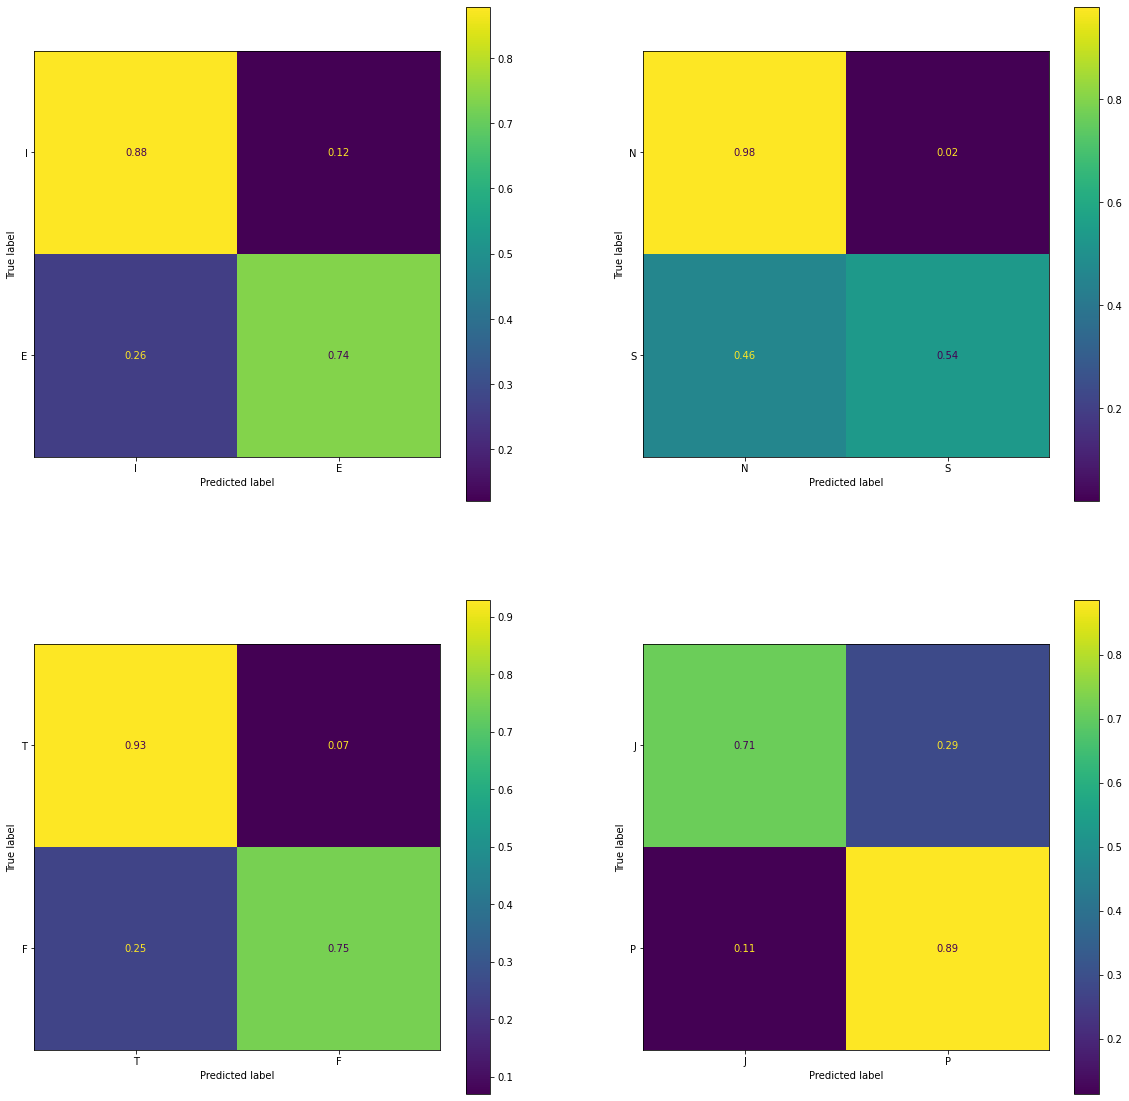

In [ ]:
mbti_arrays = [['I', 'E'], ['N', 'S'], ['T', 'F'], ['J', 'P']]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 20))
axes = [ax1, ax2, ax3, ax4]
for i in range(4):
    cm = confusion_matrix(y_true_array[:, i], y_pred_array[:, i], labels=[0, 1], normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mbti_arrays[i])
    disp.plot(ax=axes[i])
    
for i in range(4):
    print(f'Results of {mbti_arrays[i]}:')
    print('Accuracy:', accuracy_score(y_true_array[:, i], y_pred_array[:, i]))
    print('F1 score:',f1_score(y_true_array[:, i], y_pred_array[:, i], average='weighted'))
    print('Precision:',precision_score(y_true_array[:, i], y_pred_array[:, i], average='weighted'))
    print('Recall:',recall_score(y_true_array[:, i], y_pred_array[:, i], average='weighted'))

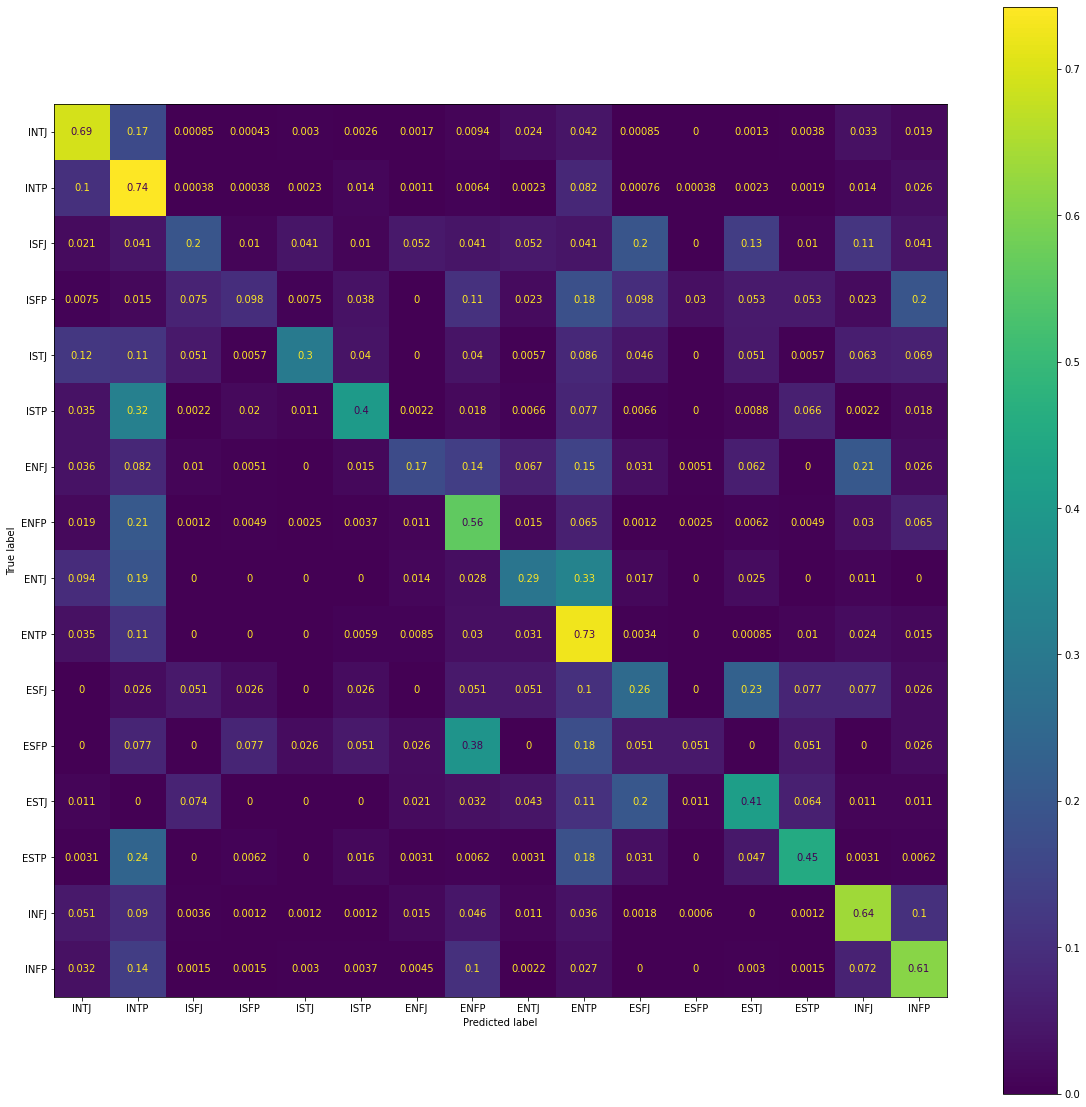

In [ ]:
y_true_ints = [convert_personality_type_to_int(convert_binary_to_personality_type(i)) for i in y_true_array]
y_pred_ints = [convert_personality_type_to_int(convert_binary_to_personality_type(i)) for i in y_pred_array]
mbti_types = [
                'INTJ', 'INTP', 'ISFJ', 'ISFP',
                'ISTJ', 'ISTP', 'ENFJ', 'ENFP',
                'ENTJ', 'ENTP','ESFJ', 'ESFP',
                'ESTJ', 'ESTP', 'INFJ', 'INFP'
            ]

fig, ax = plt.subplots(figsize=(20, 20))
cm = confusion_matrix(y_true_ints, y_pred_ints, labels=[i for i in range(16)], normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mbti_types)
disp.plot(ax=ax)

In [ ]:
print('Accuracy:', accuracy_score(y_true_ints, y_pred_ints))
print('F1 score:',f1_score(y_true_ints, y_pred_ints, average='weighted'))
print('Precision:',precision_score(y_true_ints, y_pred_ints, average='weighted'))
print('Recall:', recall_score(y_true_ints, y_pred_ints, average='weighted'))

Accuracy: 0.6203415495919913
F1 score: 0.615359087218945
Precision: 0.6281825265074505
Recall: 0.6203415495919913
